# Message passing neural network for segment classification on ACTS data

In this notebook we'll implement a model similar to the Interaction Networks model:
https://arxiv.org/abs/1612.00222

The model will consider a graph of connected hits and try to determine which edges are real and which are spurious.

The difference between this notebook and the MPNN_Seg_ACTS notebook is that this will be looking at full events.

In [1]:
# Training concurrency
import os
os.environ['OMP_NUM_THREADS'] = '4'
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

cuda = True

In [2]:
# System imports
from __future__ import print_function
import os
import multiprocessing as mp
from timeit import default_timer as timer

# Externals
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.metrics
from sklearn.model_selection import train_test_split

# Torch imports
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

# Local imports
from estimator import Estimator
from acts import process_hits_files, select_barrel_hits

%matplotlib notebook

In [3]:
if cuda:
    np_to_torch = lambda x, volatile=False: (
        Variable(torch.from_numpy(x.astype(np.float32)), volatile=volatile).cuda())
else:
    np_to_torch = lambda x, volatile=False: (
        Variable(torch.from_numpy(x.astype(np.float32)), volatile=volatile))

torch_to_np = lambda x: x.cpu().data.numpy()

## Data utilities

In [4]:
def select_hits(hits):
    # Select all barrel hits
    vids = [8, 13, 17]
    hits = hits[np.logical_or.reduce([hits.volid == v for v in vids])]
    # Re-enumerate the volume and layer numbers for convenience
    volume = pd.Series(-1, index=hits.index, dtype=np.int8)
    vid_groups = hits.groupby('volid')
    for i, v in enumerate(vids):
        volume[vid_groups.get_group(v).index] = i
    # This assumes 4 layers per volume (except last volume)
    layer = (hits.layid / 2 - 1 + volume * 4).astype(np.int8)
    # Select the columns we need
    hits = (hits[['evtid', 'barcode', 'r', 'phi', 'z']]
            .assign(volume=volume, layer=layer))
    # Filter tracks that hit every layer
    #hits = (hits.groupby(['evtid', 'barcode'])
    #        .filter(lambda x: len(x.layer.unique()) == 10))
    # Remove duplicate hits
    hits = hits.loc[
        hits.groupby(['evtid', 'barcode', 'layer'], as_index=False).r.idxmin()
    ]
    return hits

In [5]:
def draw_sample(X, Ri, Ro, y, cmap='bwr_r', alpha_labels=False):
    # Select the i/o node features for each segment
    feats_o = X[np.where(Ri.T)[1]]
    feats_i = X[np.where(Ro.T)[1]]
    # Prepare the figure
    fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(9,4))
    cmap = plt.get_cmap(cmap)
    
    # Draw the hits (r, phi, z)
    ax0.scatter(X[:,2], X[:,0], c='k')
    ax1.scatter(X[:,1], X[:,0], c='k')
    
    # Draw the segments
    for j in range(y.shape[0]):
        if alpha_labels:
            seg_args = dict(c='k', alpha=float(y[j]))
        else:
            seg_args = dict(c=cmap(float(y[j])))
        ax0.plot([feats_o[j,2], feats_i[j,2]],
                 [feats_o[j,0], feats_i[j,0]], '-', **seg_args)
        ax1.plot([feats_o[j,1], feats_i[j,1]],
                 [feats_o[j,0], feats_i[j,0]], '-', **seg_args)
    # Adjust axes
    ax0.set_xlabel('$z$ [mm]')
    ax1.set_xlabel('$\phi$ [rad]')
    ax0.set_ylabel('$r$ [mm]')
    ax1.set_ylabel('$r$ [mm]')
    plt.tight_layout()

In [6]:
def calc_dphi(phi1, phi2):
    """Computes phi2-phi1 given in range [-pi,pi]"""
    dphi = phi2 - phi1
    dphi[dphi > np.pi] -= 2*np.pi
    dphi[dphi < -np.pi] += 2*np.pi
    return dphi

In [7]:
def construct_graph(hits,
                    feature_names, feature_scale,
                    dphi_max=np.pi/4, dz_max=300,
                   ):
    """Construct the graph for a single event sample"""
    # Pull out useful variables
    layers = hits.layer.values
    phi = hits.phi.values
    z = hits.z.values
    pid = hits.barcode.values
    # Adjacent layer constraint
    adj_layer = (layers[None,:] - layers[:,None]) == 1
    # Delta-phi constraint
    adj_dphi = (np.abs(calc_dphi(phi[None,:], phi[:,None])) < dphi_max)
    # Delta-Z constraint
    adj_dz = (np.abs(z[None,:] - z[:,None]) < dz_max)
    # Final adjacency
    adj_total = np.logical_and.reduce([adj_layer, adj_dphi, adj_dz])
    # (start, end) node indices of each edge
    edge_idx = np.stack(np.where(adj_total), axis=1)
    # Node features
    X = hits[feature_names].values / feature_scale
    # Node-edge association matrices
    n_hits = X.shape[0]
    n_edges = edge_idx.shape[0]
    Ri = np.zeros((n_hits, n_edges), dtype=np.uint8)
    Ro = np.zeros((n_hits, n_edges), dtype=np.uint8)
    y = np.zeros(n_edges)
    # Fill the matrices
    Ri[edge_idx[:,1], np.arange(n_edges)] = 1
    Ro[edge_idx[:,0], np.arange(n_edges)] = 1
    pid_in = np.matmul(pid[None], Ri).squeeze(0)
    pid_out = np.matmul(pid[None], Ro).squeeze(0)
    y = (pid_in == pid_out)
    return X, Ri, Ro, y

## Prepare the data

In [8]:
input_dir = '/bigdata/shared/ACTS/prod_mu10_pt1000_2017_07_29'

In [9]:
all_files = os.listdir(input_dir)
hits_files = sorted(f for f in all_files if f.startswith('clusters'))

n_files = 20
hits_files = [os.path.join(input_dir, hf) for hf in hits_files[:n_files]]

In [10]:
%%time

n_workers = 5
with mp.Pool(processes=n_workers) as pool:
    hits = process_hits_files(hits_files, pool)
    print('Applying selections')
    hits = pool.map(select_hits, hits)

# Concatenate everything together
hits = pd.concat(hits, ignore_index=True)

Loading /bigdata/shared/ACTS/prod_mu10_pt1000_2017_07_29/clusters_1.csv
Loading /bigdata/shared/ACTS/prod_mu10_pt1000_2017_07_29/clusters_100.csv
Loading /bigdata/shared/ACTS/prod_mu10_pt1000_2017_07_29/clusters_12.csv
Loading /bigdata/shared/ACTS/prod_mu10_pt1000_2017_07_29/clusters_11.csv
Loading /bigdata/shared/ACTS/prod_mu10_pt1000_2017_07_29/clusters_10.csv
Loading /bigdata/shared/ACTS/prod_mu10_pt1000_2017_07_29/clusters_13.csv
Loading /bigdata/shared/ACTS/prod_mu10_pt1000_2017_07_29/clusters_14.csv
Loading /bigdata/shared/ACTS/prod_mu10_pt1000_2017_07_29/clusters_15.csv
Loading /bigdata/shared/ACTS/prod_mu10_pt1000_2017_07_29/clusters_16.csv
Loading /bigdata/shared/ACTS/prod_mu10_pt1000_2017_07_29/clusters_17.csv
Loading /bigdata/shared/ACTS/prod_mu10_pt1000_2017_07_29/clusters_18.csv
Loading /bigdata/shared/ACTS/prod_mu10_pt1000_2017_07_29/clusters_19.csv
Loading /bigdata/shared/ACTS/prod_mu10_pt1000_2017_07_29/clusters_2.csv
Loading /bigdata/shared/ACTS/prod_mu10_pt1000_2017_0

## Construct the dataset

In [17]:
evtids = hits.evtid.unique()
print('Number of available events:', evtids.shape[0])

Number of available events: 19930


In [ ]:
n_samples = evtids.shape[0]

feature_names = ['r', 'phi', 'z']
n_features = len(feature_names)
feature_scale = np.array([1000., np.pi, 1000.])

# Filter based on occupancy to make things feasible for development
n_nodes_min = 50
n_nodes_max = 500
n_edges_max = 1000

In [ ]:
%%time

all_X, all_Ri, all_Ro, all_y = [], [], [], []
for i in range(n_samples):
    evt_hits = hits[hits.evtid == evtids[i]]
    X, Ri, Ro, y = construct_graph(evt_hits, feature_names, feature_scale)
    
    # Apply filter requirements
    n_nodes = X.shape[0]
    n_edges = y.shape[0]
    if (n_nodes > n_nodes_min) and (n_nodes < n_nodes_max) and (n_edges < n_edges_max):
        
        # Save this event
        all_X.append(X)
        all_Ri.append(Ri)
        all_Ro.append(Ro)
        all_y.append(y)

In [19]:
# Filtered samples
n_samples = len(all_X)

In [20]:
print('Filtered samples:', n_samples)

Filtered samples: 8933


## Visualize one sample

<IPython.core.display.Javascript object>


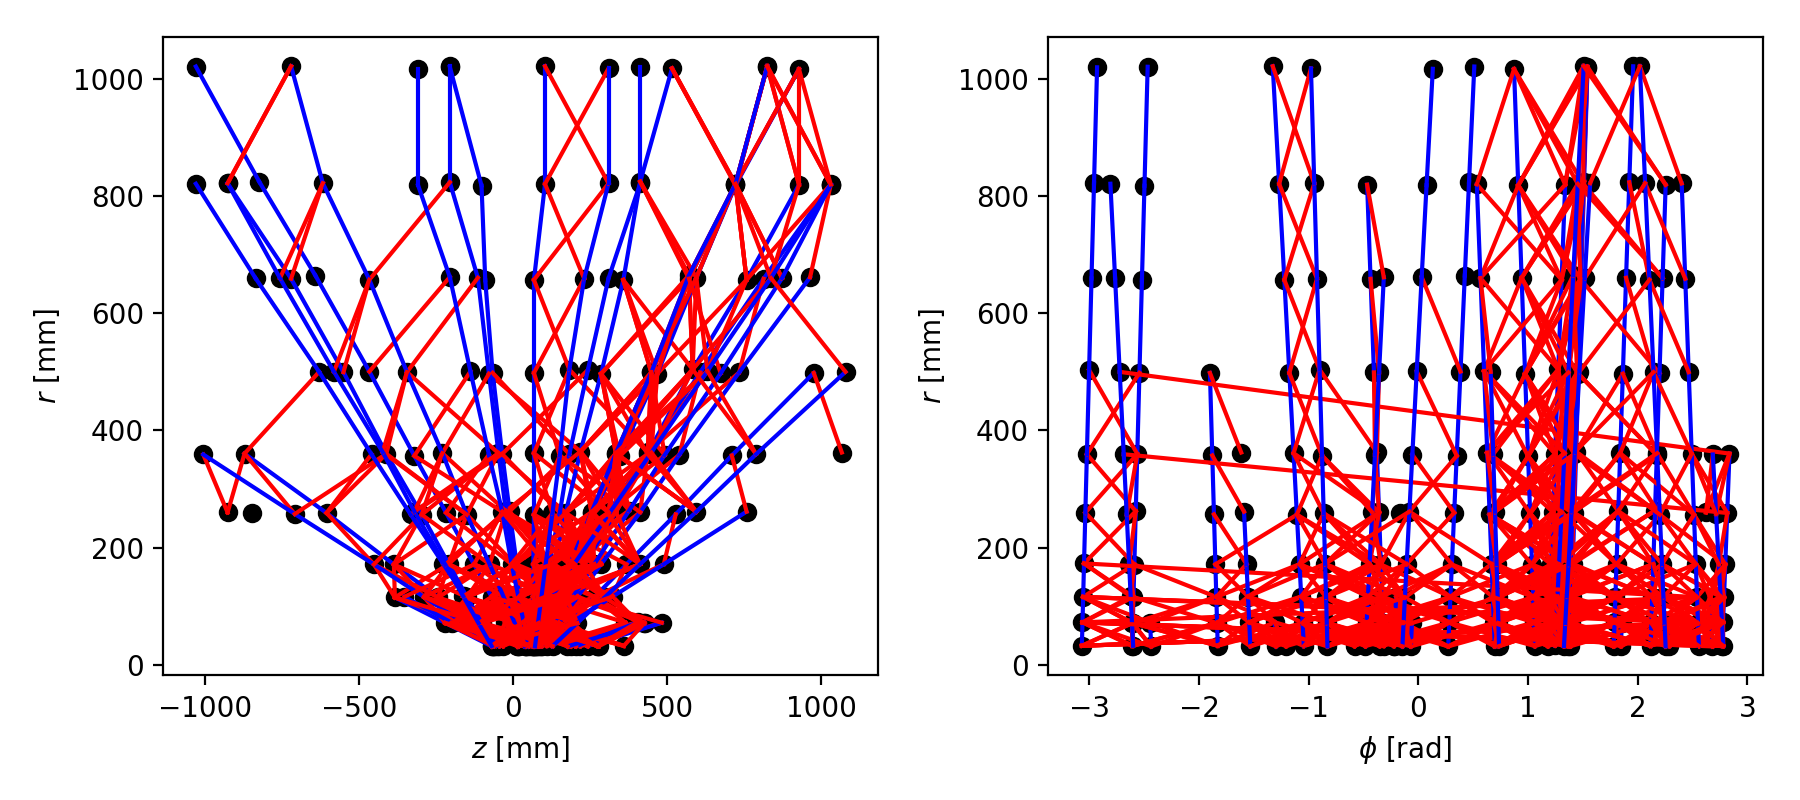

In [21]:
i = 6
draw_sample(all_X[i] * feature_scale, all_Ri[i], all_Ro[i], all_y[i])

## Define data generator

Since every event is unique, we need something which can batch things together into batch-specific tensors.

It should just use the max size required for that sample.

In [22]:
def merge_samples(X, Ri, Ro, y):
    # Get the sizes for this batch
    n = len(X)
    n_features = X[0].shape[1]
    n_nodes = np.array([X[i].shape[0] for i in range(n)])
    n_edges = np.array([y[i].shape[0] for i in range(n)])
    max_nodes = n_nodes.max()
    max_edges = n_edges.max()

    # Allocate the tensors for this batch
    batch_X = np.zeros((n, max_nodes, n_features), dtype=np.float32)
    batch_Ri = np.zeros((n, max_nodes, max_edges), dtype=np.uint8)
    batch_Ro = np.zeros((n, max_nodes, max_edges), dtype=np.uint8)
    batch_y = np.zeros((n, max_edges), dtype=np.uint8)

    # Loop over samples and fill the tensors
    for i in range(n):
        batch_X[i, :n_nodes[i]] = X[i]
        batch_Ri[i, :n_nodes[i], :n_edges[i]] = Ri[i]
        batch_Ro[i, :n_nodes[i], :n_edges[i]] = Ro[i]
        batch_y[i, :n_edges[i]] = y[i]
    
    return batch_X, batch_Ri, batch_Ro, batch_y

In [23]:
def batch_generator(X, Ri, Ro, y, n_samples=1, batch_size=1, train=True):
    volatile = not train
    batch_idxs = np.arange(0, n_samples, batch_size)
    # Loop over epochs
    while True:
        # Loop over batches
        for j in batch_idxs:
            batch_X, batch_Ri, batch_Ro, batch_y = merge_samples(
                X[j:j+batch_size], Ri[j:j+batch_size], Ro[j:j+batch_size], y[j:j+batch_size])
            batch_inputs = [
                np_to_torch(batch_X, volatile=volatile),
                np_to_torch(batch_Ri, volatile=volatile),
                np_to_torch(batch_Ro, volatile=volatile)]
            batch_target = np_to_torch(batch_y, volatile=volatile)
            yield batch_inputs, batch_target

## Define the model

In [24]:
class EdgeNetwork(nn.Module):
    """
    A module which computes weights for edges of the graph.
    For each edge, it selects the associated nodes' features
    and applies some fully-connected network layers with a final
    sigmoid activation.
    """
    def __init__(self, input_dim, hidden_dim=8, hidden_activation=nn.Tanh):
        super(EdgeNetwork, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_dim*2, hidden_dim),
            hidden_activation(),
            nn.Linear(hidden_dim, 1),
            nn.Sigmoid())
    def forward(self, X, Ri, Ro):
        # Select the features of the associated nodes
        bo = torch.matmul(Ro.transpose(1, 2), X)
        bi = torch.matmul(Ri.transpose(1, 2), X)
        B = torch.cat([bo, bi], dim=2)
        # Apply the network to each edge
        return self.network(B).squeeze(-1)

class NodeNetwork(nn.Module):
    """
    A module which computes new node features on the graph.
    For each node, it aggregates the neighbor node features
    (separately on the input and output side), and combines
    them with the node's previous features in a fully-connected
    network to compute the new features.
    """
    def __init__(self, input_dim, output_dim, hidden_activation=nn.Tanh):
        super(NodeNetwork, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_dim*3, output_dim),
            hidden_activation(),
            nn.Linear(output_dim, output_dim),
            hidden_activation())
    def forward(self, X, e, Ri, Ro):
        bo = torch.matmul(Ro.transpose(1, 2), X)
        bi = torch.matmul(Ri.transpose(1, 2), X)
        Rwo = Ro * e[:,None]
        Rwi = Ri * e[:,None]
        mi = torch.matmul(Rwi, bo)
        mo = torch.matmul(Rwo, bi)
        M = torch.cat([mi, mo, X], dim=2)
        return self.network(M)

class SegmentClassifier(nn.Module):
    def __init__(self, input_dim=2, hidden_dim=8, n_iters=3, hidden_activation=nn.Tanh):
        super(SegmentClassifier, self).__init__()
        self.n_iters = n_iters
        # Setup the input network
        self.input_network = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            hidden_activation())
        # Setup the edge network
        self.edge_network = EdgeNetwork(input_dim+hidden_dim, hidden_dim, hidden_activation)
        # Setup the node layers
        self.node_network = NodeNetwork(input_dim+hidden_dim, hidden_dim, hidden_activation)

    def forward(self, inputs):
        """Apply forward pass of the model"""
        X, Ri, Ro = inputs
        # Apply input network to get hidden representation
        H = self.input_network(X)
        # Shortcut connect the inputs onto the hidden representation
        H = torch.cat([H, X], dim=-1)
        # Loop over iterations of edge and node networks
        for i in range(self.n_iters):
            # Apply edge network
            e = self.edge_network(H, Ri, Ro)
            # Apply node network
            H = self.node_network(H, e, Ri, Ro)
            # Shortcut connect the inputs onto the hidden representation
            H = torch.cat([H, X], dim=-1)
        # Apply final edge network
        return self.edge_network(H, Ri, Ro)

## Test the model on merged batches

## Train the model

In [63]:
# Model config
hidden_dim = 32
n_iters = 4

# Training config
batch_size = 4
n_epochs = 8
valid_frac = 0.2
test_frac = 0.2

In [64]:
# We round by batch_size to avoid partial batches
n_test = int(n_samples * test_frac) // batch_size * batch_size
n_valid = int(n_samples * valid_frac) // batch_size * batch_size
n_train = (n_samples - n_valid - n_test) // batch_size * batch_size
n_train_batches = n_train // batch_size
n_valid_batches = n_valid // batch_size
n_test_batches = n_test #// batch_size

n_train, n_valid, n_test, n_train + n_valid + n_test

(5364, 1784, 1784, 8932)

In [65]:
# Partition the dataset
(train_X, test_X, train_Ri, test_Ri, train_Ro, test_Ro, train_y, test_y) = (
    train_test_split(all_X, all_Ri, all_Ro, all_y, test_size=n_test))
(train_X, valid_X, train_Ri, valid_Ri, train_Ro, valid_Ro, train_y, valid_y) = (
    train_test_split(train_X, train_Ri, train_Ro, train_y, test_size=n_valid))

In [66]:
print('Train shapes:', len(train_X), len(train_Ri), len(train_Ro), len(train_y))
print('Valid shapes:', len(valid_X), len(valid_Ri), len(valid_Ro), len(valid_y))
print('Test shapes: ', len(test_X), len(test_Ri), len(test_Ro), len(test_y))

Train shapes: 5365 5365 5365 5365
Valid shapes: 1784 1784 1784 1784
Test shapes:  1784 1784 1784 1784


In [67]:
# Prepare the batch generators
train_batcher = batch_generator(train_X, train_Ri, train_Ro, train_y,
                                n_samples=n_train, batch_size=batch_size)
valid_batcher = batch_generator(valid_X, valid_Ri, valid_Ro, valid_y, train=False,
                                n_samples=n_valid, batch_size=batch_size)
test_batcher = batch_generator(test_X, test_Ri, test_Ro, test_y, train=False,
                               n_samples=n_test, batch_size=1)

In [68]:
# Construct the model
model = SegmentClassifier(input_dim=n_features, hidden_dim=hidden_dim, n_iters=n_iters)
loss_func = nn.BCELoss()
estim = Estimator(model, loss_func=loss_func, cuda=cuda)

2018-03-21 14:16:44.907023 Model: 
SegmentClassifier(
  (input_network): Sequential(
    (0): Linear(in_features=3, out_features=32, bias=True)
    (1): Tanh()
  )
  (edge_network): EdgeNetwork(
    (network): Sequential(
      (0): Linear(in_features=70, out_features=32, bias=True)
      (1): Tanh()
      (2): Linear(in_features=32, out_features=1, bias=True)
      (3): Sigmoid()
    )
  )
  (node_network): NodeNetwork(
    (network): Sequential(
      (0): Linear(in_features=105, out_features=32, bias=True)
      (1): Tanh()
      (2): Linear(in_features=32, out_features=32, bias=True)
      (3): Tanh()
    )
  )
)
2018-03-21 14:16:44.907452 Parameters: 6881


In [69]:
estim.fit_gen(train_batcher, n_batches=n_train_batches, n_epochs=n_epochs,
              valid_generator=valid_batcher, n_valid_batches=n_valid_batches)

2018-03-21 14:16:47.087311 Epoch 0
2018-03-21 14:17:03.909166   training loss 0.283 time 16.8217s
2018-03-21 14:17:07.307204   validate loss 0.159
2018-03-21 14:17:07.307316 Epoch 1
2018-03-21 14:17:24.070251   training loss 0.121 time 16.7629s
2018-03-21 14:17:27.380269   validate loss 0.102
2018-03-21 14:17:27.380378 Epoch 2
2018-03-21 14:17:44.127811   training loss 0.0972 time 16.7471s
2018-03-21 14:17:47.493833   validate loss 0.0916
2018-03-21 14:17:47.493939 Epoch 3
2018-03-21 14:18:04.487073   training loss 0.0898 time 16.993s
2018-03-21 14:18:07.898795   validate loss 0.0861
2018-03-21 14:18:07.898910 Epoch 4
2018-03-21 14:18:24.653677   training loss 0.0854 time 16.7547s
2018-03-21 14:18:28.007366   validate loss 0.0815
2018-03-21 14:18:28.007470 Epoch 5
2018-03-21 14:18:44.715222   training loss 0.0735 time 16.7076s
2018-03-21 14:18:48.116009   validate loss 0.0573
2018-03-21 14:18:48.116377 Epoch 6
2018-03-21 14:19:04.817597   training loss 0.051 time 16.701s
2018-03-21 14:

### Loss curves

<IPython.core.display.Javascript object>


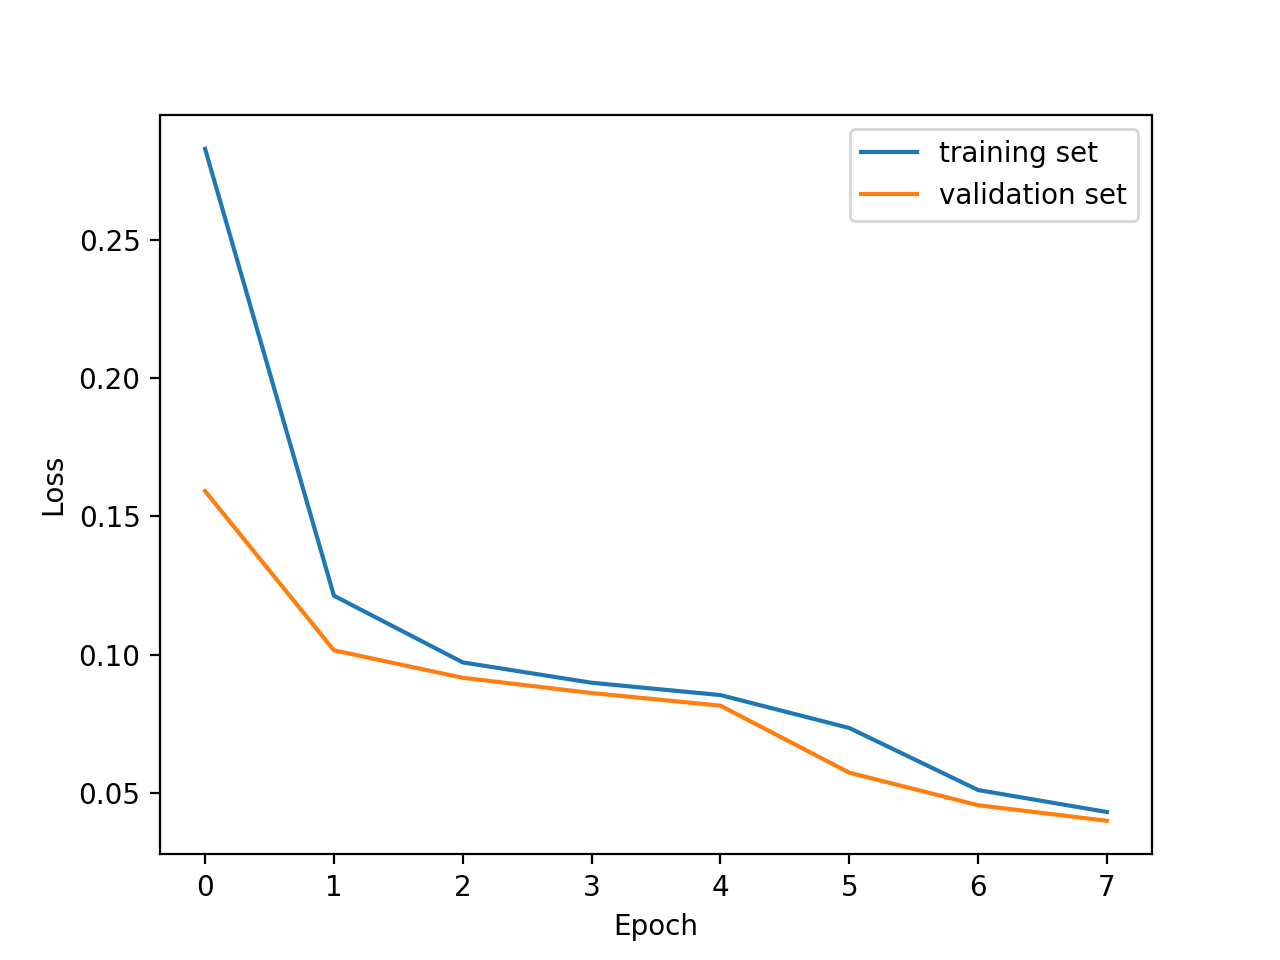

In [70]:
# Plot the loss
plt.figure()
plt.plot(estim.train_losses, label='training set')
plt.plot(estim.valid_losses, label='validation set')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc=0);

## Evaluate model on the test set

Some challenges here. Because of the way I pad in the batches, I have to somehow un-pad in order to compute final metrics.

In [78]:
# Easiest to use a batch size of 1 for the test sample
test_batcher = batch_generator(test_X, test_Ri, test_Ro, test_y, train=False,
                               n_samples=n_test, batch_size=1)

In [80]:
n_test_batches = n_test

In [81]:
test_outputs = estim.predict(test_batcher, n_test_batches, concat=False)
test_preds = [torch_to_np(o) for o in test_outputs]

In [83]:
# Flatten the predictions and labels
flat_y = np.concatenate([p.flatten() for p in test_y])
flat_pred = np.concatenate([p.flatten() for p in test_preds])

In [86]:
thresh = 0.5
print('Test set results with threshold of', thresh)
print('Accuracy:  %.4f' % sklearn.metrics.accuracy_score(flat_y, flat_pred>thresh))
print('Precision: %.4f' % sklearn.metrics.precision_score(flat_y, flat_pred>thresh))
print('Recall:    %.4f' % sklearn.metrics.recall_score(flat_y, flat_pred>thresh))

Test set results with threshold of 0.5
Accuracy:  0.9743
Precision: 0.9541
Recall:    0.9481


In [87]:
# Compute the ROC curve
fpr, tpr, _ = sklearn.metrics.roc_curve(flat_y, flat_pred)

<IPython.core.display.Javascript object>


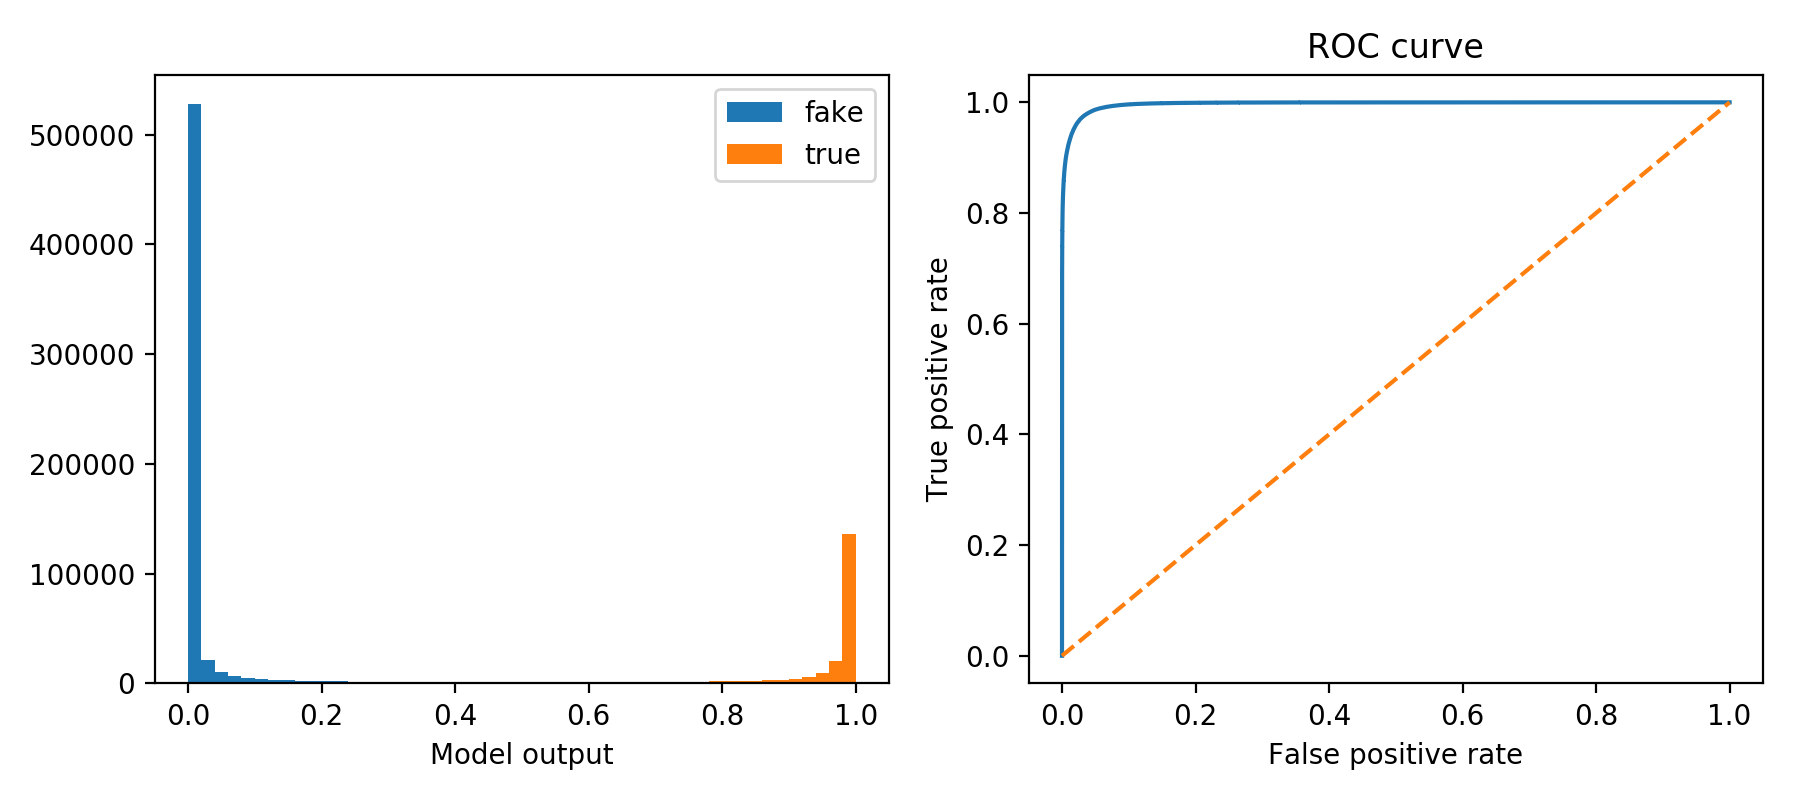

In [88]:
plt.figure(figsize=(9,4))

# Plot the model outputs
plt.subplot(121)
binning=dict(bins=50, range=(0,1), histtype='bar')
plt.hist(flat_pred[flat_y<0.5], label='fake', **binning)
plt.hist(flat_pred[flat_y>0.5], label='true', **binning)
plt.xlabel('Model output')
plt.legend(loc=0)

# Plot the ROC curve
plt.subplot(122)
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], '--')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')

plt.tight_layout()

## Visualize some samples

accuracy 0.976, precision 0.970, recall 0.970


<IPython.core.display.Javascript object>


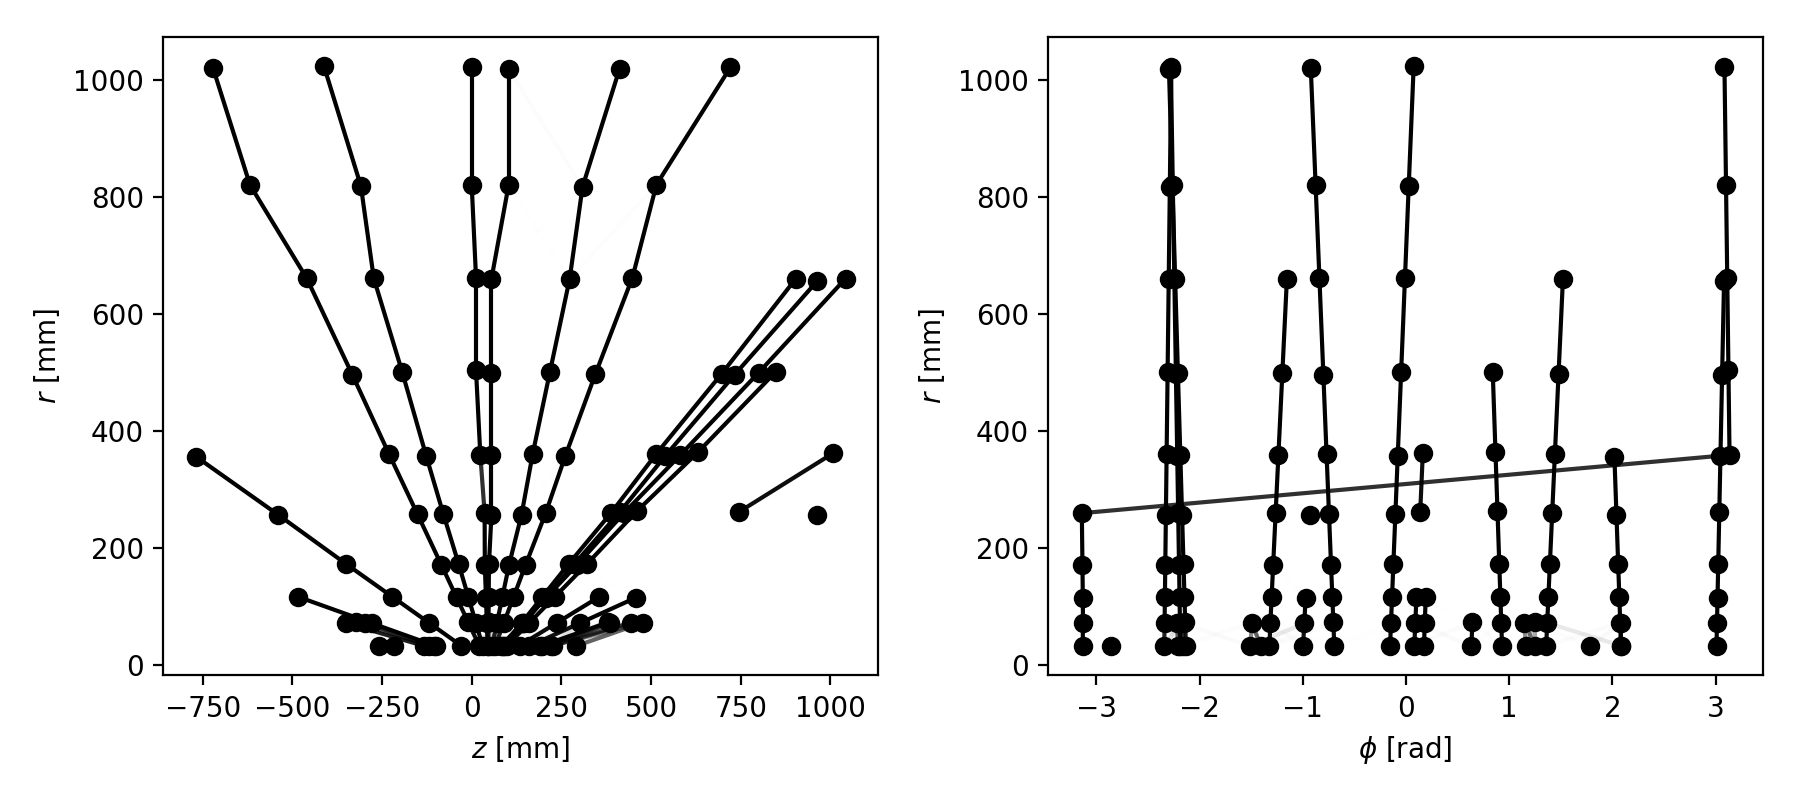

accuracy 0.970, precision 0.947, recall 0.964


<IPython.core.display.Javascript object>


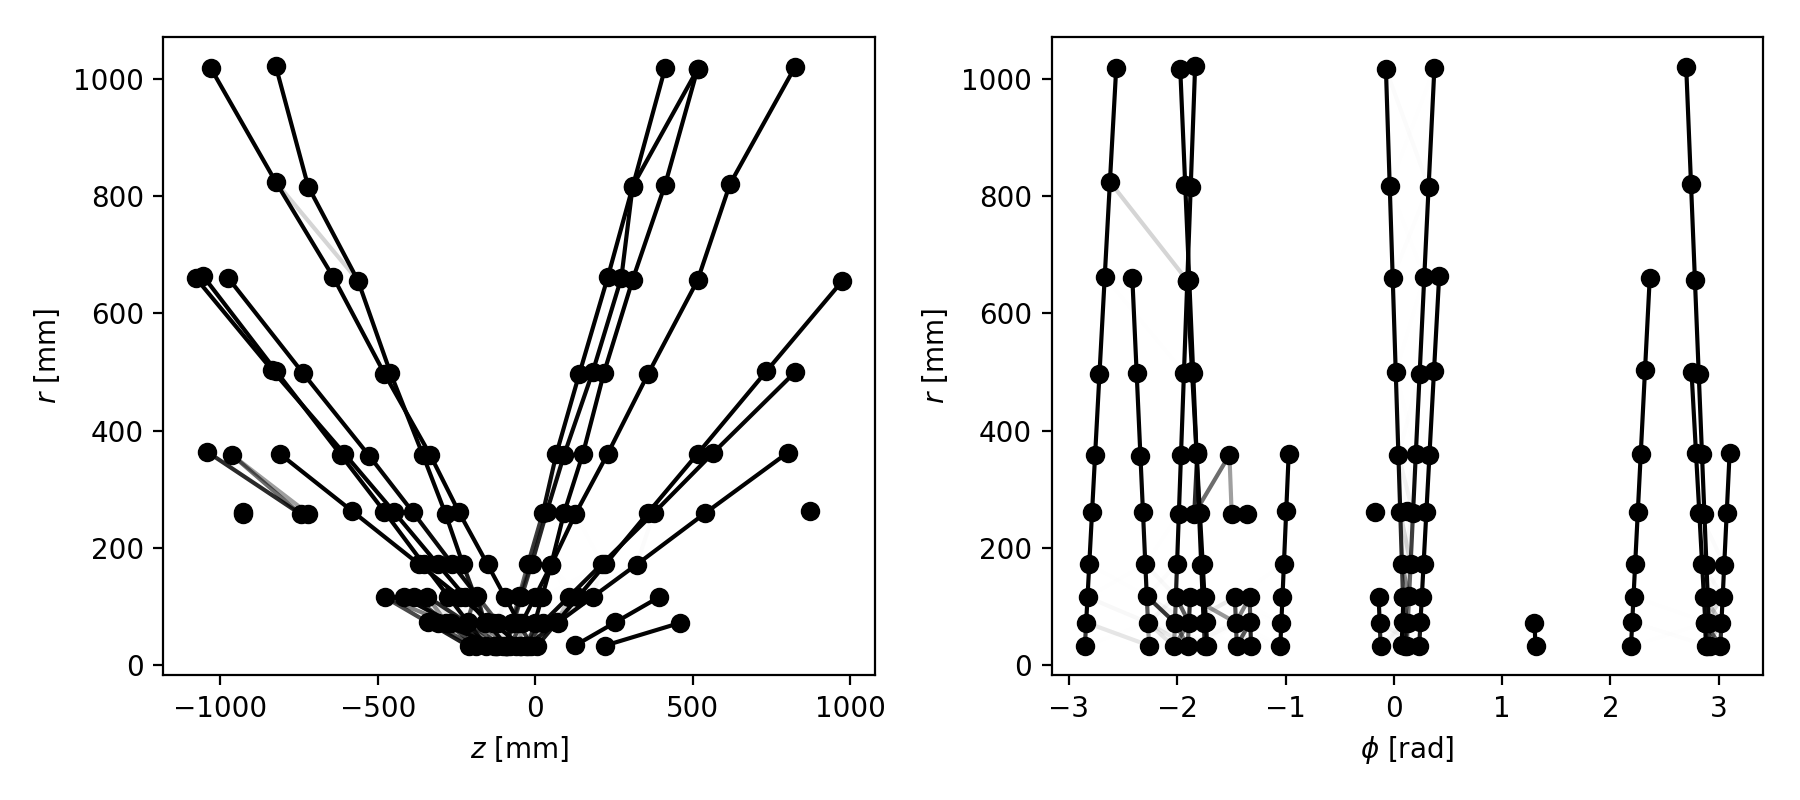

accuracy 0.986, precision 0.967, recall 0.980


<IPython.core.display.Javascript object>


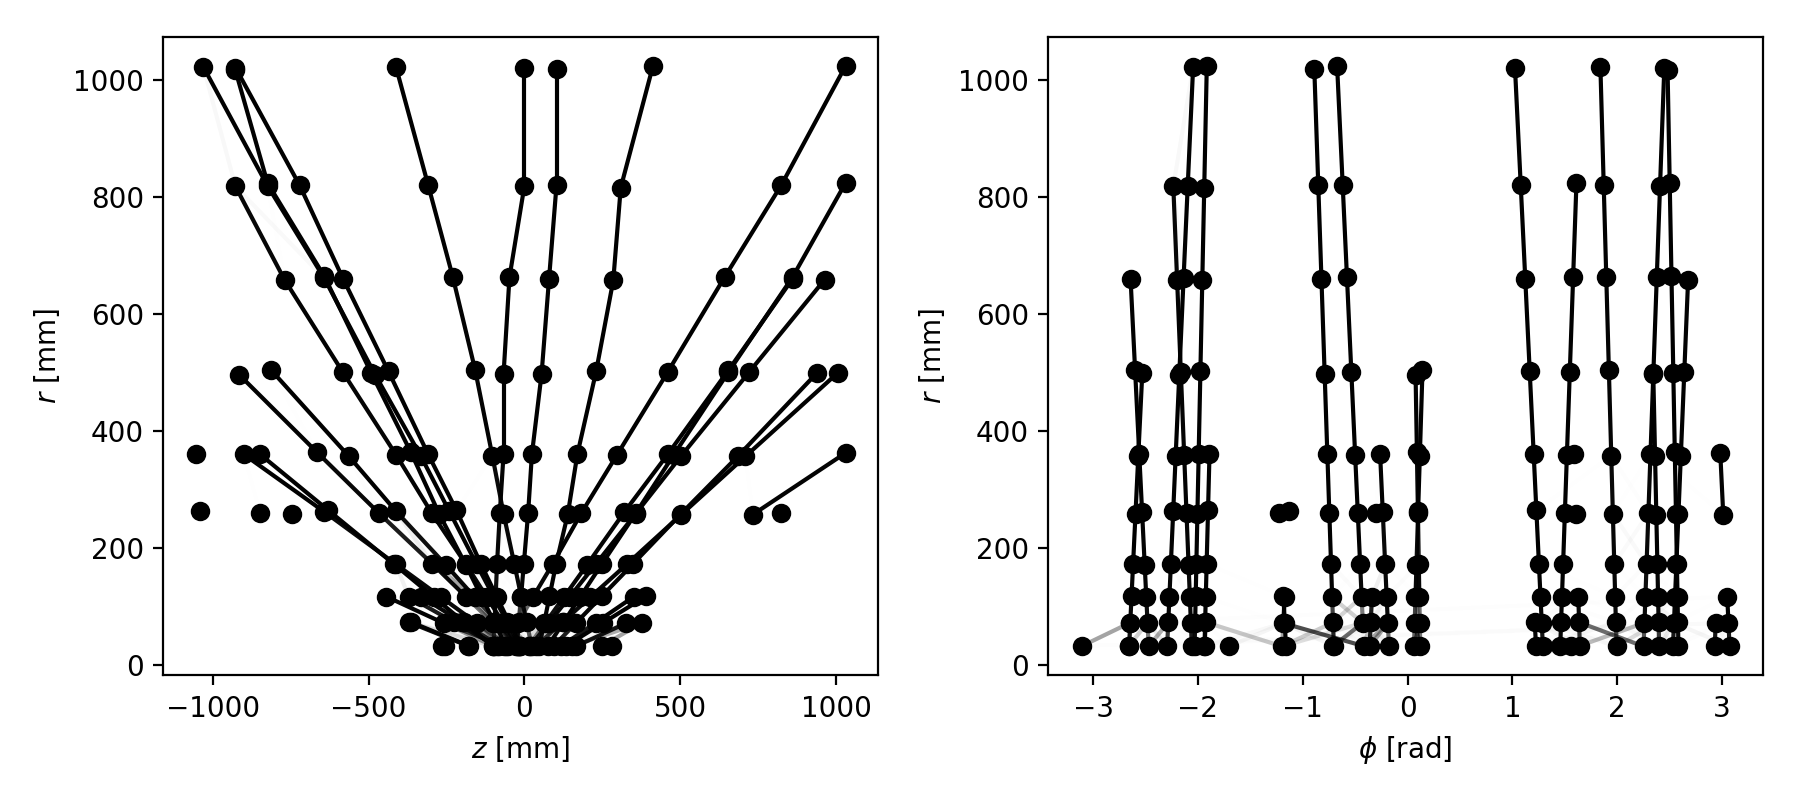

accuracy 0.970, precision 0.951, recall 0.911


<IPython.core.display.Javascript object>


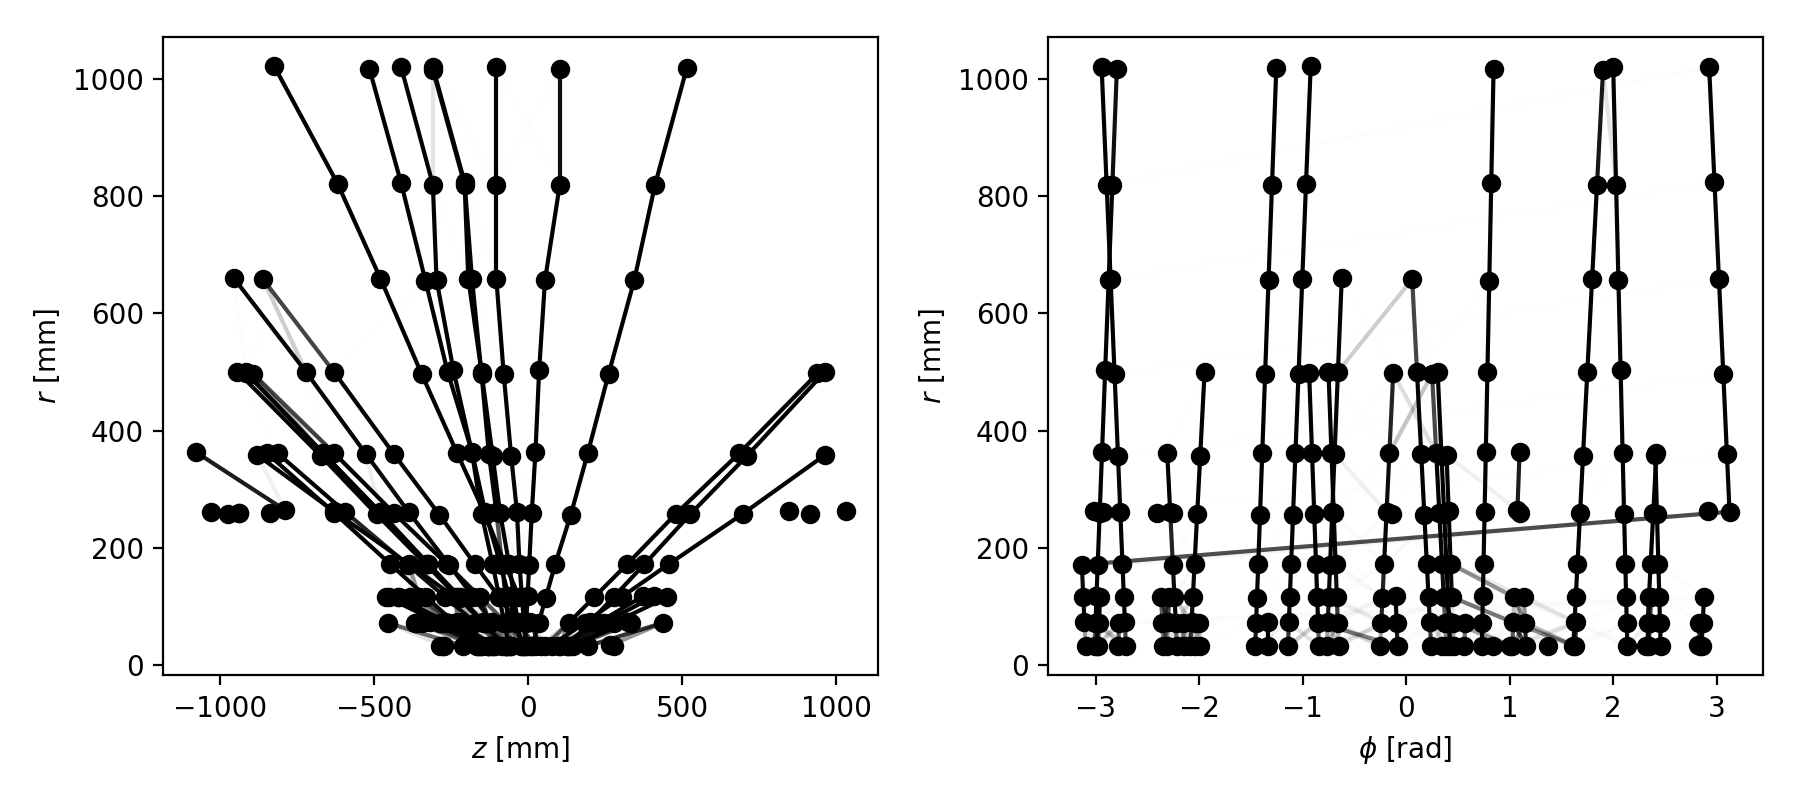

In [99]:
# Draw some samples
for i in range(4):
    X = test_X[i] * feature_scale
    Ri = test_Ri[i]
    Ro = test_Ro[i]
    pred = test_preds[i].squeeze(0)
    y = test_y[i]
    print('accuracy %.3f, precision %.3f, recall %.3f' % (
        sklearn.metrics.accuracy_score(y, pred>thresh),
        sklearn.metrics.precision_score(y, pred>thresh),
        sklearn.metrics.recall_score(y, pred>thresh)))
    draw_sample(X, Ri, Ro, pred, alpha_labels=True);